In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

2025-02-17 03:17:00.144547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 03:17:00.145158: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 03:17:00.147473: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 03:17:00.154015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739783820.165643 1171337 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739783820.16

In [2]:
# Variables de configuración
prediction_col = 'Sales' # Definir el nombre de la columna objetivo que queremos predecir (en este caso, 'Sales')
init_prev_weeks = 2 # Definir el número de semanas desde las que se van a realizar promedios
end_prev_weeks = 8 # Definir el número de semanas hasta las que se van a realizar promedios
augmentation_rounds = 2 # Definir el número de rondas de aumento de datos que se realizarán
look_back = 5  # Número de semanas previas que usamos para predecir la siguiente en los modelos BLSTM
np.random.seed(46)

### Functions

In [3]:
def evaluate_regression_model(y_pred, y_true):
    """
    Evalúa un modelo de regresión calculando las métricas RMSE, MSE, MAE, R² y MAPE.

    Parameters:
    - y_pred: Las predicciones del modelo.
    - y_true: Las etiquetas reales.

    Returns:
    - Diccionario con las métricas de evaluación.
    """   
    mse = mean_squared_error(y_true, y_pred) # MSE (Mean Squared Error)
    rmse = np.sqrt(mse) # RMSE (Root Mean Squared Error)
    mae = mean_absolute_error(y_true, y_pred) # MAE (Mean Absolute Error)
    r2 = r2_score(y_true, y_pred) # R² (Coeficiente de determinación)

    # MAPE (Mean Absolute Percentage Error)
    # Evitando división por cero, solo se calcula para valores donde y_true no es cero.
    non_zero_mask = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    # Diccionario con las métricas
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

    return metrics

In [4]:
def plot_comparison(y_pred, y_true, X_test, X_train, y_train, y_pred_train, flag_plot_pred_train=True):
    """
    Grafica una comparación entre las ventas reales (y_true) y las predicciones (y_pred) tanto para
    el conjunto de entrenamiento como para el de prueba.

    Parameters:
    - y_pred: Predicciones sobre el conjunto de prueba.
    - y_true: Valores reales del conjunto de prueba.
    - X_test: Conjunto de datos de prueba (usado para los índices).
    - X_train: Conjunto de datos de entrenamiento (usado para los índices).
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_pred_train: Predicciones sobre el conjunto de entrenamiento.
    - flag_plot_pred_train: Bandera que indica si se deben graficar los datos predecidos del entrenamiento
    """
    
    # Crear índices si X_train y X_test son arrays de numpy (sin índice)
    if isinstance(X_train, np.ndarray):
        train_indices = range(len(X_train))  # Crear un rango basado en la longitud
    else:
        train_indices = X_train.index  # Usar el índice si es un DataFrame de pandas

    if isinstance(X_test, np.ndarray):
        test_indices = range(len(X_test))  # Crear un rango basado en la longitud
    else:
        test_indices = X_test.index  # Usar el índice si es un DataFrame de pandas

    # Crear la figura para graficar
    plt.figure(figsize=(12, 6))

    # Graficar los valores reales y las predicciones para el entrenamiento
    plt.plot(train_indices, y_train, label='Ventas reales (Entrenamiento)', color='blue')
    if flag_plot_pred_train:
        plt.plot(train_indices, y_pred_train, label='Predicciones (Entrenamiento)', color='red', linestyle='--')

    # Graficar los valores reales y las predicciones para el test después de los de entrenamiento
    plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label='Ventas reales (Prueba)', color='green')
    plt.plot(range(len(y_pred_train), len(y_pred_train) + len(y_pred)), y_pred, label='Predicciones (Prueba)', color='orange', linestyle='--')

    # Configuración de la gráfica
    plt.legend()
    plt.title('Comparación de Ventas Reales vs Predicciones')
    plt.xlabel('Semana')
    plt.ylabel('Ventas')
    plt.grid(True)
    plt.show()


In [5]:


def augment_data(df, noise_factor_sales=0.01, flip_probability=0.1):
    """
    Realiza un aumento de datos agregando ruido aleatorio a las columnas de Sales, Promotion y Holiday.
    Para las columnas binarias (Promotion y Holiday), se realiza un cambio aleatorio con una probabilidad dada.

    Parameters:
    - df: DataFrame de entrada con las columnas Sales, Promotion y Holiday.
    - noise_factor_sales: El valor de desviación estándar para agregar ruido a Sales (por defecto 0.01).
    - flip_probability: Probabilidad de flip (0 a 1) para las columnas binarias (por defecto 0.1).

    Returns:
    - DataFrame aumentado con ruido añadido a las columnas correspondientes.
    """
    
    # Copiar el DataFrame original para no modificarlo directamente
    df_augmented = df.copy()

    # Añadir ruido aleatorio a la columna 'Sales'
    df_augmented['Sales'] += np.random.normal(0, noise_factor_sales, size=df['Sales'].shape) * df_augmented['Sales']

    # Para las columnas binarias ('Promotion' y 'Holiday')
    # Realizamos un flip aleatorio con la probabilidad de flip_probability
    for col in ['Promotion', 'Holiday']:
        # Flipear aleatoriamente las etiquetas con la probabilidad flip_probability
        flip_mask = np.random.rand(len(df)) < flip_probability
        df_augmented[col] = df[col].where(~flip_mask, 1 - df[col])

    return df_augmented


In [6]:
def feature_engineering(df_, flag_original):
    """
    Realiza el proceso de ingeniería de características sobre el DataFrame de entrada.
    Se crean nuevas características que incluyen la venta y la promoción de las semanas previas, 
    estadísticas de las últimas semanas y algunas transformaciones adicionales.

    Parameters:
    - df_: DataFrame que contiene las columnas necesarias para el procesamiento (Sales, Promotion, Holiday).
    - flag_original: bandera que se utiliza para agregar la columna 'original' al resultado.

    Returns:
    - df: DataFrame con nuevas características añadidas, como estadísticas de ventas y transformaciones adicionales.
    """
    # Copiar el DataFrame original para evitar modificaciones directas
    df = df_.copy()
    
    # Creación de características que reflejan las ventas, promociones y festividades de la semana anterior
    # La función shift() mueve los valores de una columna para simular la venta o promoción de la semana pasada
    df['Prev_Week_Promotion'] = df['Promotion'].shift(1).fillna(0).astype(int)  # Promoción de la semana anterior
    df['Prev_Week_Holiday'] = df['Holiday'].shift(1).fillna(0).astype(int)  # Festividad de la semana anterior
    df['Prev_Week_Sales'] = df['Sales'].shift(1).fillna(0).astype(int)  # Ventas de la semana anterior
    df['Prev_2_Week_Sales'] = df['Sales'].shift(2).fillna(0).astype(int)  # Ventas de hace dos semanas
    
    # Calcular el promedio y desviación estándar de las ventas, promoción y festividades de las últimas X semanas
    # Esto se realiza mediante una ventana de desplazamiento 'rolling' para promediar las columnas de ventas, promoción y festividades
    for prev_weeks in range(init_prev_weeks, end_prev_weeks+1):
        # Promedios para las 'prev_weeks' semanas anteriores
        df[f'Avg_Promotion_prev_{prev_weeks}_Weeks'] = df['Prev_Week_Promotion'].rolling(window=prev_weeks, min_periods=1).mean()
        df[f'Avg_Holiday_prev_{prev_weeks}_Weeks']  = df['Prev_Week_Holiday'].rolling(window=prev_weeks, min_periods=1).mean()
        df[f'Avg_Sales_prev_{prev_weeks}_Weeks'] = df['Prev_Week_Sales'].rolling(window=prev_weeks, min_periods=1).mean()
        
        # Desviación estándar para las 'prev_weeks' semanas anteriores
        df[f'Std_Sales_prev_{prev_weeks}_Weeks'] = df['Prev_Week_Sales'].rolling(window=prev_weeks, min_periods=1).std()
    
    # Calcular la diferencia y proporción de ventas entre las últimas 2 semanas
    df['Sales_diff_prev_2_weeks'] = df['Prev_Week_Sales'] - df['Prev_2_Week_Sales']  # Diferencia de ventas
    df['Sales_proportion_prev_2_weeks'] = df['Prev_Week_Sales'] / df['Prev_2_Week_Sales']  # Proporción de ventas

    # Crear una característica que combine las promociones y festividades de la semana actual
    df['Promotion_and_Holiday'] = df['Promotion'] * df['Holiday']  # Interacción entre promoción y festividad

    # Logaritmo de las ventas de la semana anterior (se usa para estabilizar la varianza)
    df['Log_Sales_prev_week'] = np.log(df['Prev_Week_Sales'])
    
    # Agregar la columna 'original' del DataFrame original para preservar los datos originales
    df['original'] = flag_original

    # Rellenar los valores nulos con 0
    df = df.fillna(0)
    
    # Reemplazar valores infinitos por 0 para evitar errores durante el entrenamiento de modelos
    df = df.replace([np.inf, -np.inf], 0)
    
    # Devolver el DataFrame con las nuevas características
    return df

### Preprocessing

In [7]:
df_ = pd.read_csv("sales_ml.csv") # Leer el archivo CSV con los datos de ventas
df_ = df_.sort_values(by='Week') # Ordenar el DataFrame por la columna 'Week' (Semana) para tener los datos en orden cronológico
df_eval = df_[df_['Sales'].isna()].copy() # Crear un DataFrame con las filas donde la columna 'Sales' es NaN (es decir, donde faltan las ventas)
df = df_[df_['Sales'].notna()].copy() # Crear un DataFrame con las filas donde la columna 'Sales' no es NaN (es decir, donde las ventas están presentes)
df.head(2) # Mostrar las primeras dos filas del DataFrame 'df' para verificar los datos

,Week,Product,Sales,Promotion,Holiday
0,1,Product_1,152.0,1,0
1,2,Product_1,485.0,0,0


In [8]:
# Generar las características para el DataFrame 'df' usando la función 'feature_engineering'
df_features = feature_engineering(df, 'True')
df_concat = df_features.copy() # Hacer una copia del DataFrame de características para luego concatenar los datos aumentados

# Realizar las rondas de aumento de datos
for i in range(augmentation_rounds):
    # Aumentar los datos en cada ronda y generar nuevas características con 'feature_engineering'
    df_aux = feature_engineering(augment_data(df), 'False')
    
    # Concatenar los nuevos datos aumentados al DataFrame original
    # Se realiza un 'concat' y luego se ordenan por la columna 'Week' para mantener el orden cronológico
    df_concat = pd.concat([df_concat, df_aux], ignore_index=True).sort_values(by=['Week', 'Sales'], ascending=[True, False])

# Resetear los índices del DataFrame concatenado para asegurarse de que sean continuos
df_concat.reset_index(drop=True, inplace=True)

# Obtener los índices originales (donde la columna 'original' es True) para identificarlos más tarde
df_index_original = df_concat[df_concat['original'] == True].index

# Crear el DataFrame final, eliminando las columnas no necesarias ('Product', 'Week', 'original')
df_final = df_concat.drop(columns=['Product', 'Week', 'original'])

/home/acer-2050/.cache/pypoetry/virtualenvs/meli-exercise-vkg9_jxp-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/acer-2050/.cache/pypoetry/virtualenvs/meli-exercise-vkg9_jxp-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/acer-2050/.cache/pypoetry/virtualenvs/meli-exercise-vkg9_jxp-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Mostrar las primeras 2 filas del DataFrame
df_final.head(2)

,Sales,Promotion,Holiday,Prev_Week_Promotion,Prev_Week_Holiday,Prev_Week_Sales,Prev_2_Week_Sales,Avg_Promotion_prev_2_Weeks,Avg_Holiday_prev_2_Weeks,Avg_Sales_prev_2_Weeks,...,Avg_Sales_prev_7_Weeks,Std_Sales_prev_7_Weeks,Avg_Promotion_prev_8_Weeks,Avg_Holiday_prev_8_Weeks,Avg_Sales_prev_8_Weeks,Std_Sales_prev_8_Weeks,Sales_diff_prev_2_weeks,Sales_proportion_prev_2_weeks,Promotion_and_Holiday,Log_Sales_prev_week
0,152.889011,1,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0
1,152.000000,1,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0


In [10]:
# Separar las características (X) de la columna objetivo (y)
X = df_final.drop(columns=prediction_col)
y = df_final[prediction_col]

In [11]:
# Definir el índice de división (80% entrenamiento, 20% prueba)
train_size = int(len(df_final) * 0.8)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Lightgbm model

In [12]:
# Crear el dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parámetros del modelo LightGBM
params = {
    'objective': 'regression',  # Tipo de tarea (regresión para predecir un número continuo)
    'metric': 'rmse',           # Medida para evaluar el rendimiento (root mean squared error)
    'boosting_type': 'gbdt',    # Tipo de boosting (Gradient Boosting Decision Tree)
    'num_leaves': 31,           # Número de hojas en los árboles
    'learning_rate': 0.1,      # Tasa de aprendizaje
    'feature_fraction': 0.9,    # Fracción de características que se utilizan en cada iteración
    'bagging_fraction': 0.8,    # Fracción de datos utilizados en cada iteración
    'bagging_freq': 5,          # Frecuencia de bagging (1 cada 5 iteraciones)
    'verbose': -1,               # Para evitar mensajes detallados
    'max_depth': 6              # Limita la profundidad máxima de los árboles
}

# Entrenar el modelo LightGBM con early stopping
num_round = 1000  # Número de iteraciones
model_lgbm = lgb.train(params, train_data, num_round, valid_sets=[test_data],
                  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])

# Hacer predicciones con el modelo entrenado
y_pred = model_lgbm.predict(X_test, num_iteration=model_lgbm.best_iteration)
y_pred_train = model_lgbm.predict(X_train, num_iteration=model_lgbm.best_iteration)

# Evaluación del modelo: Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 144.511
Early stopping, best iteration is:
[5]	valid_0's rmse: 126.814
Root Mean Squared Error (RMSE): 126.81378734256822


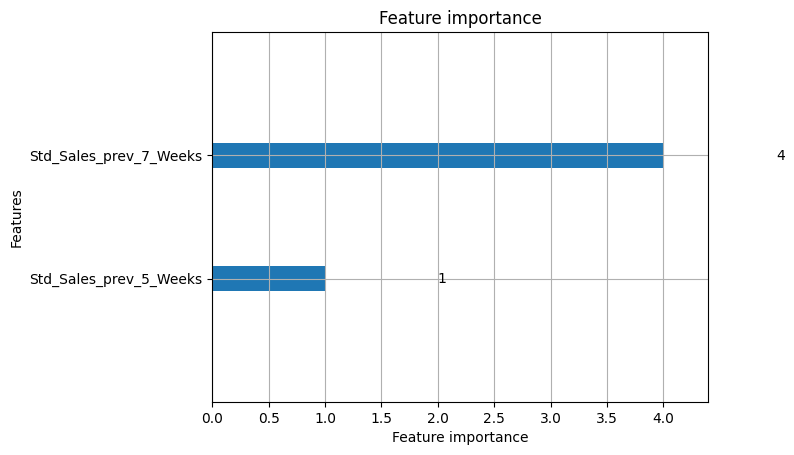

In [13]:
lgb.plot_importance(model_lgbm, max_num_features=10, importance_type='split')
plt.show()

In [14]:
metrics_lgbm = evaluate_regression_model(y_pred, y_test)
metrics_lgbm

{'MSE': 16081.736660166116,
 'RMSE': np.float64(126.81378734256822),
 'MAE': 107.69760710881243,
 'R²': -1.1017361793251492,
 'MAPE': np.float64(26.205697370785163)}

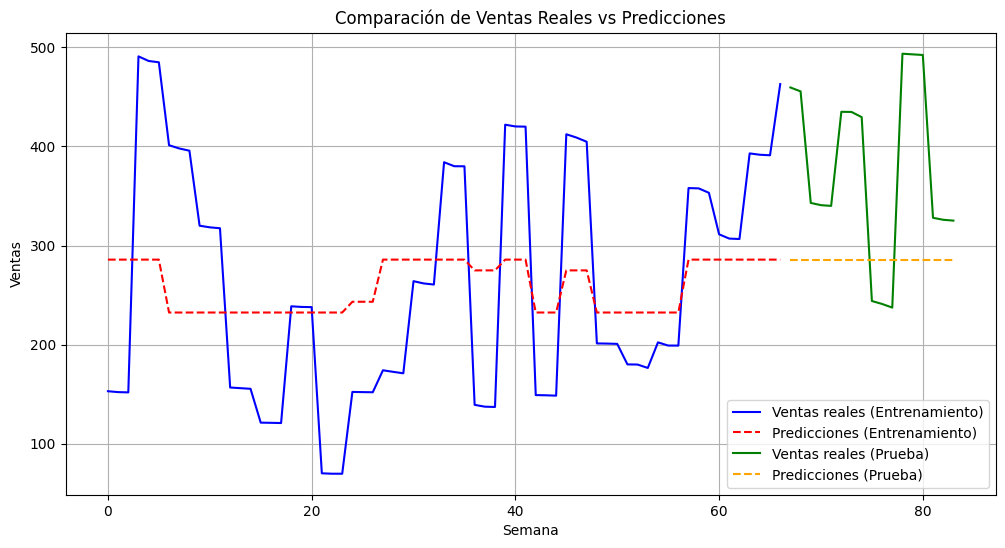

In [15]:
plot_comparison(y_pred, y_test, X_test, X_train, y_train, y_pred_train)

# Linear regression

In [16]:
# Escalar las características (opcional, para regresión lineal y otros modelos)
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# Regresión lineal
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_lr = linear_regressor.predict(X_test_scaled)
y_train_pred_lr = linear_regressor.predict(X_train_scaled)

# Calcular el RMSE para la regresión lineal
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"RMSE de Regresión Lineal: {rmse_lr}")

RMSE de Regresión Lineal: 103.01650527423267


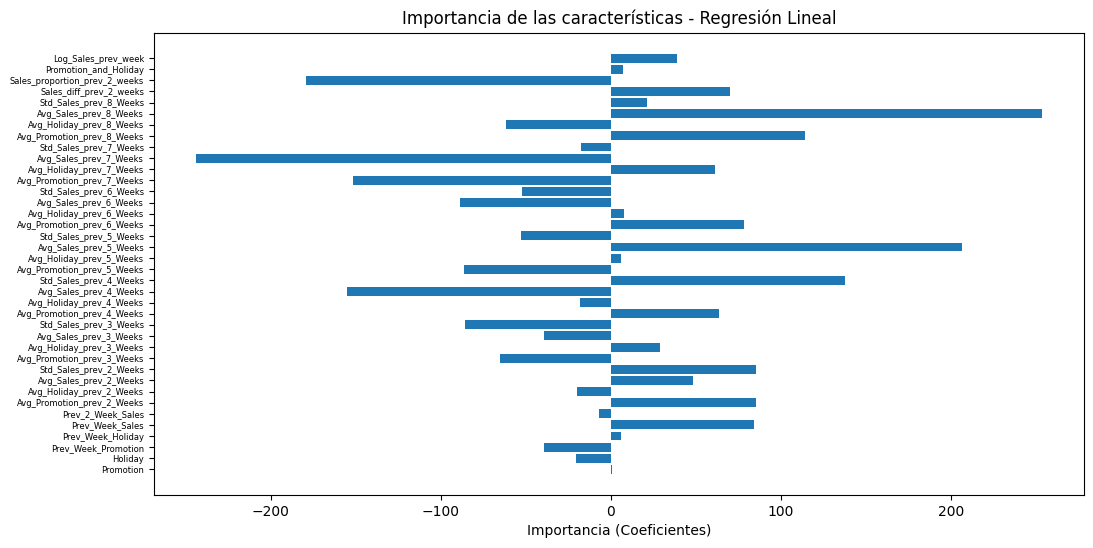

In [17]:
# Obtener los coeficientes de la regresión lineal (importancia de características)
coef = linear_regressor.coef_

# Crear un gráfico de barras para mostrar la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(coef)), coef, align='center')
plt.yticks(np.arange(len(coef)), X_train.columns, fontsize=6)  # Cambiar el tamaño de la fuente aquí
plt.xlabel('Importancia (Coeficientes)')
plt.title('Importancia de las características - Regresión Lineal')
plt.show()

In [18]:
metrics_lr = evaluate_regression_model(y_pred_lr, y_test)
metrics_lr

{'MSE': 10612.400358916007,
 'RMSE': np.float64(103.01650527423267),
 'MAE': 83.63848631425424,
 'R²': -0.38694385159684463,
 'MAPE': np.float64(21.747390872253565)}

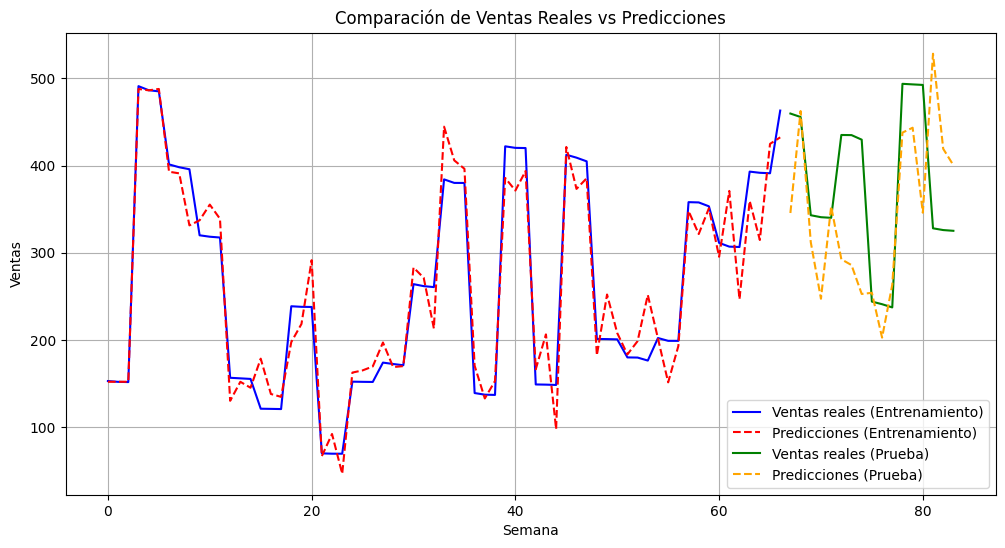

In [19]:
plot_comparison(y_pred_lr, y_test, X_test, X_train, y_train, y_train_pred_lr )

# XGBoost

In [ ]:
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,              # Ajusta a un valor más bajo para evitar sobreajuste
    learning_rate=0.01,            # Utiliza un learning rate bajo
    max_depth=5,                   # Árboles más pequeños
    min_child_weight=1,            # Ajusta a 1 para evitar divisiones demasiado específicas
    subsample=0.8,                 # Submuestra más pequeña para evitar sobreajuste
    colsample_bytree=0.7,          # Menos características por árbol para generalizar mejor
    gamma=0.1,                     # Un poco de regularización para evitar sobreajuste
    reg_alpha=0.2,                 # Regularización L1 ligera
    reg_lambda=0.5                 # Regularización L2 ligera
)

# Entrenar el modelo
model_xgb.fit(X_train, y_train)

# Hacer predicciones sobre los datos de prueba
y_pred_xgb= model_xgb.predict(X_test)
y_train_pred_xgb= model_xgb.predict(X_train)

# Evaluación del modelo: Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'Root Mean Squared Error (RMSE): {rmse}')

In [ ]:
# Importancia de las características
xgb.plot_importance(model_xgb, max_num_features=10, importance_type='weight')
plt.show()

In [ ]:
metrics_xgb = evaluate_regression_model(y_pred_xgb, y_test)
metrics_xgb

In [ ]:
plot_comparison(y_pred_xgb, y_test,  X_test, X_train, y_train, y_train_pred_xgb)

# Arima

In [ ]:
train_size_arima = int(len(df) * 0.8)
train, test = df[:train_size_arima], df[train_size_arima:]

model_arima = ARIMA(train['Sales'], order=(5, 1, 0))  # (p, d, q)
model_fit = model_arima.fit()
print(model_fit.summary())
forecast = model_fit.forecast(steps=len(test))

In [ ]:
metrics_arima = evaluate_regression_model(forecast, test['Sales'])
metrics_arima

In [ ]:
plot_comparison(forecast, test['Sales'], test, train, train['Sales'], train['Sales'], False)

# Arimax

In [ ]:
model_arimax = ARIMA(y_train, exog=X_train, order=(1, 1, 1))
model_fit_arimax = model_arimax.fit()
y_pred_arimax = model_fit_arimax.forecast(steps=len(X_test), exog=X_test)
y_train_pred_arimax = model_fit_arimax.forecast(steps=len(X_train), exog=X_train)

In [ ]:
metrics_arimax = evaluate_regression_model(y_pred_arimax, y_test)
metrics_arimax

In [ ]:
plot_comparison(y_pred_arimax, y_test,  X_test, X_train, y_train, y_train_pred_arimax, False)

# BLSTM

In [ ]:
# Configurar para usar la CPU
tf.config.set_visible_devices([], 'GPU')  # Desactiva todas las GPUs

# Normalizar las variables para que estén en el rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_final)

# Crear las secuencias de datos para entrenar el modelo (X, y)
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, 0])  # 0 corresponde a 'Sales' que es la variable objetivo
    return np.array(X), np.array(y)


X_blstm, y_blstm = create_dataset(scaled_data, look_back)

# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_blstm = int(len(X_blstm) * 0.8)
X_train_blstm, X_test_blstm = X_blstm[:train_size_blstm], X_blstm[train_size_blstm:]
y_train_blstm, y_test_blstm = y_blstm[:train_size_blstm], y_blstm[train_size_blstm:]

# Definir el modelo BLSTM (Bidirectional LSTM)
model = Sequential()
# Añadir capa LSTM bidireccional con Dropout
model.add(Bidirectional(LSTM(units=64, activation='relu', return_sequences=False), input_shape=(look_back, X_train_blstm.shape[2])))
model.add(Dropout(0.2))  # Dropout para evitar overfitting
model.add(Dense(units=1)) # Capa densa para la predicción
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error') # Reducir la tasa de aprendizaje

# Entrenar el modelo
history = model.fit(X_train_blstm, y_train_blstm, epochs=500, batch_size=16, validation_data=(X_test_blstm, y_test_blstm), verbose=1)

# Hacer predicciones sobre el conjunto de prueba
y_pred_blstm = model.predict(X_test_blstm)

# Hacer predicciones sobre el conjunto de entrenamiento
y_train_pred = model.predict(X_train_blstm)
y_test_blstm.shape, y_pred_blstm.shape, X_train_blstm.shape[2]

# Asegúrandonos de que todas las variables son numpy arrays
y_test_blstm = np.array(y_test_blstm)
y_pred_blstm = np.array(y_pred_blstm)
y_train = np.array(y_train)
y_train_pred = np.array(y_train_pred)

# Revertir la normalización de las predicciones y los valores reales para el conjunto de prueba
y_test_blstm_rescaled = scaler.inverse_transform(np.hstack((y_test_blstm.reshape(-1, 1), np.zeros((len(y_test_blstm), df_final.shape[1]-1)))))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred_blstm.reshape(-1, 1), np.zeros((len(y_pred_blstm), df_final.shape[1]-1)))))[:, 0]

# Revertir la normalización de las predicciones y los valores reales para el conjunto de entrenamiento
y_train_rescaled = scaler.inverse_transform(np.hstack((y_train_blstm.reshape(-1, 1), np.zeros((len(y_train_blstm), df_final.shape[1]-1)))))[:, 0]
y_train_pred_rescaled = scaler.inverse_transform(np.hstack((y_train_pred.reshape(-1, 1), np.zeros((len(y_train_pred), df_final.shape[1]-1)))))[:, 0]


In [ ]:
metrics_blstm = evaluate_regression_model(y_pred_rescaled, y_test_blstm_rescaled)
metrics_blstm

In [ ]:
plot_comparison(y_pred_rescaled, y_test_blstm_rescaled, X_test_blstm, X_train_blstm, y_train_rescaled, y_train_pred_rescaled)

# Hyperparmeter tuning with Optuna

In [ ]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd


# Definir la función de optimización
def objective(trial):
    # Probar diferentes valores para los parámetros del modelo
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),           # Número de hojas
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Tasa de aprendizaje
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),  # Fracción de características
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),  # Fracción de datos
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),            # Frecuencia de bagging
        'max_depth': trial.suggest_int('max_depth', 3, 12),                   # Profundidad máxima del árbol
        'verbose': -1
    }

    # Crear el dataset de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Entrenar el modelo con los parámetros sugeridos por Optuna
    num_round = 1000
    model = lgb.train(params, train_data, num_round, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    # Realizar predicciones y calcular el RMSE
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE

    return rmse

# Crear el estudio de Optuna y realizar la optimización
study = optuna.create_study(direction='minimize')  # Minimizar el RMSE
study.optimize(objective, n_trials=50)  # Realizar 50 intentos

# Imprimir los mejores parámetros y el mejor RMSE
print('Best RMSE: ', study.best_value)
print('Best parameters: ', study.best_params)

# Puedes usar los mejores parámetros para entrenar un modelo final si lo deseas
best_params = study.best_params
final_model = lgb.train(best_params, train_data, num_round, valid_sets=[test_data])

# Realizar las predicciones con el mejor modelo
final_predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final RMSE with optimized parameters: {final_rmse}")


In [ ]:
# Realizar las predicciones con el mejor modelo
final_predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final RMSE with optimized parameters: {final_rmse}")

In [ ]:
# Aunque se realizó la búsqueda de hiperparámetros, estos no fueron mejores que aquellos seleccionados de forma empírica

# Metrics

In [ ]:
metrics_df = pd.DataFrame({
    'LGBM': metrics_lgbm.values(),
    'LR': metrics_lr.values(),
    'XGB': metrics_xgb.values(),
    'ARIMA': metrics_arima.values(),
    'ARIMAX': metrics_arimax.values(),
    'BLSTM': metrics_blstm.values()
}, index=metrics_lgbm.keys())

# Mostrar la tabla con las métricas
metrics_df = metrics_df.transpose()

In [ ]:
metrics_df

# Evaluation

In [ ]:
def evaluate_model(df_aux, model, feature_engineering, model_type, scaler=None, end_prev_weeks=8):
    """
    Función genérica para la evaluación de modelos.
    
    df_aux: DataFrame
        DataFrame que contiene los datos de ventas y otras características.
    model: modelo entrenado
        El modelo previamente entrenado que se va a utilizar para la predicción.
    feature_engineering: función
        La función que realiza el procesamiento de características para la evaluación.
    model_type: str
        Tipo de modelo ('LGBM', 'LinearRegression', 'XGB', 'ARIMAX')
    scaler: (opcional) 
        Si el modelo requiere un escalado, se debe proporcionar el scaler correspondiente.
    end_prev_weeks: int
        Número de semanas previas a usar para las predicciones.
        
    Retorna el DataFrame actualizado con las predicciones de ventas.
    """
    for i, row in df_eval.iterrows():
        # Filtrar las semanas anteriores
        df_weeks_previous = df_aux[df_aux['Week'] <= row['Week']].tail(end_prev_weeks + 1)
        
        # Generar las características para la evaluación
        df_eval_features = feature_engineering(df_weeks_previous, 'True')
        X_eval = df_eval_features.iloc[[-1]].drop(columns=['Product', 'Week', 'original', 'Sales'])

        # Predicción según el tipo de modelo
        if model_type == 'LGBM':
            y_eval_pred = model.predict(X_eval)
        elif model_type == 'LinearRegression':
            y_eval_pred = model.predict(scaler.transform(X_eval))  # Escalado para regresión lineal
        elif model_type == 'XGB':
            y_eval_pred = model.predict(X_eval)
        elif model_type == 'ARIMAX':
            y_eval_pred = model.forecast(steps=1, exog=X_eval).values[0]
        else:
            raise ValueError(f"Modelo {model_type} no reconocido")

        # Asignar la predicción a la columna 'Sales' en el DataFrame
        df_aux.loc[df_aux['Week'] == row['Week'], 'Sales'] = y_eval_pred
    
    return df_aux

In [ ]:
# Evaluación con LGBM
df_aux_lgbm = df_.copy()
df_aux_lgbm = evaluate_model(df_aux_lgbm, model_lgbm, feature_engineering, 'LGBM', end_prev_weeks=end_prev_weeks)

# Evaluación con Linear Regression
df_aux_lr = df_.copy()
df_aux_lr = evaluate_model(df_aux_lr, linear_regressor, feature_engineering, 'LinearRegression', scaler_lr, end_prev_weeks=end_prev_weeks)

# Evaluación con XGBoost
df_aux_xgb = df_.copy()
df_aux_xgb = evaluate_model(df_aux_xgb, model_xgb, feature_engineering, 'XGB', end_prev_weeks=end_prev_weeks)

# Evaluación con ARIMAX
df_aux_arimax = df_.copy()
df_aux_arimax = evaluate_model(df_aux_arimax, model_fit_arimax, feature_engineering, 'ARIMAX', end_prev_weeks=end_prev_weeks)

In [ ]:
# Evaluación con ARIMA
df_aux_arima = df_.copy()
forecast = model_fit.forecast(steps=len(test) + len(df_eval))
df_aux_arima.loc[df_aux_arima.index[-2:], 'Sales'] = forecast[-2:]

In [ ]:
# Evaluación con BLSTM
df_aux_blstm = df_.copy()
for i, row in df_eval.iterrows():
    df_weeks_previous = df_aux_blstm[df_aux_blstm['Week'] <= row['Week']].tail(look_back+1) 
    df_eval_features = feature_engineering(df_weeks_previous, 'True')
    df_eval_features_final = df_eval_features.drop(columns=['Product', 'Week', 'original'])
    df_eval_scaled = scaler.transform(df_eval_features_final)

    # Crear las secuencias de datos para los nuevos datos
    X_eval_blstm, _ = create_dataset(df_eval_scaled, look_back)

    predictions_new_data = model.predict(X_eval_blstm)
    predictions_new_data = np.array(predictions_new_data)
    predictions_new_rescaled = scaler.inverse_transform(np.hstack((predictions_new_data.reshape(-1, 1), np.zeros((len(predictions_new_data), df_eval_features_final.shape[1] - 1)))))[:, 0]
    
    # Guardando la predicción para la siguiente semana
    df_aux_blstm.loc[df_aux_blstm['Week'] == row['Week'], 'Sales'] = predictions_new_rescaled[0]

In [ ]:
# Columna 'Sales' con el nombre del modelo correspondiente
df_aux_lgbm = df_aux_lgbm.rename(columns={'Sales': 'Sales_LGBM'})
df_aux_lr = df_aux_lr.rename(columns={'Sales': 'Sales_LR'})
df_aux_xgb = df_aux_xgb.rename(columns={'Sales': 'Sales_XGB'})
df_aux_arima = df_aux_arima.rename(columns={'Sales': 'Sales_ARIMA'})
df_aux_arimax = df_aux_arimax.rename(columns={'Sales': 'Sales_ARIMAX'})
df_aux_blstm = df_aux_blstm.rename(columns={'Sales': 'Sales_BLSTM'}) 

# Ahora, combinamos todos los DataFrames en uno solo
df_combined = pd.concat([
    df_.copy(), 
    df_aux_lgbm[['Sales_LGBM']], 
    df_aux_lr[['Sales_LR']], 
    df_aux_xgb[['Sales_XGB']],
    df_aux_arima[['Sales_ARIMA']],
    df_aux_arimax[['Sales_ARIMAX']], 
    df_aux_blstm[['Sales_BLSTM']] 
], axis=1)

In [ ]:
df_combined

In [ ]:
# Seleccionar las columnas de las ventas de los diferentes modelos
sales_columns = ['Sales_LGBM', 'Sales_LR', 'Sales_XGB', 'Sales_ARIMA', 'Sales_ARIMAX', 'Sales_BLSTM' ]

plt.figure(figsize=(12, 8))

# Graficando la predicción de ventas de cada modelo
for column in sales_columns:
    plt.plot(df_combined['Week'], df_combined[column], label=column)
    
plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Sales Predictions for Different Models')
plt.legend()
plt.grid(True)
plt.show()
